Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Mean Squared Error (MSE): 5.772566709481453
Mean Absolute Error (MAE): 1.763038158416748
R-squared (R²): -0.3686289211643916
Explained Variance Score: -0.3619481378027132


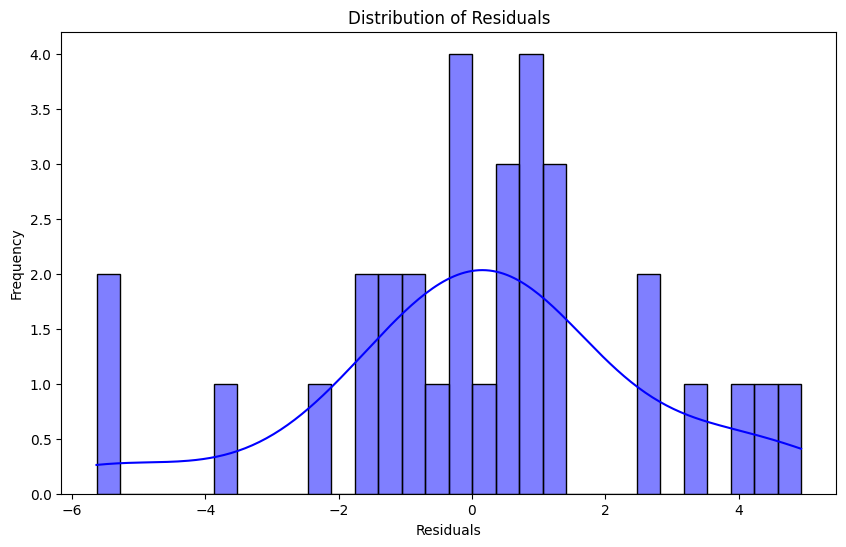

ValueError: All arrays must be of the same length

<Figure size 1000x600 with 0 Axes>

In [3]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


# Helper function to extract data from text files
def load_data(file_pattern, base_path):
    data = []
    record_ids = []
    for root, _, files in os.walk(base_path):
        for file in files:
            if re.match(file_pattern, file):
                with open(os.path.join(root, file), "r", encoding="utf-8") as f:
                    data.append(f.read())
                match = re.search(r'(Process-rec-\d{3})', file)
                if match:
                    record_ids.append(match.group(1))
    return data, record_ids

# Helper function to load labels
def load_labels(label_file):
    df = pd.read_csv(label_file)
    return df.set_index('Record-ID')[['Class', 'Age', 'Converted-MMSE']]

# Feature engineering: Calculate text and timing features
def count_interrupters_and_clean_text(text):
    interrupter_count = len(re.findall(r'\(.*?\)', text))  # Count interruptions in parentheses
    cleaned_text = re.sub(r'\(.*?\)', '', text)  # Remove parentheses content
    return interrupter_count, cleaned_text

def find_repetitions_and_timing(text):
    interrupter_count, cleaned_text = count_interrupters_and_clean_text(text)
    words = re.findall(r'\b\w+\b', cleaned_text)
    stutter_words = len(re.findall(r'\b(er|um|oh|ah|mm)\b', cleaned_text))
    meaningful_words = len(words) - stutter_words
    unique_words = len(set(words))
    word_count = len(words)
    return {
        'word_count': word_count,
        'stutter_words': stutter_words,
        'meaningful_words': meaningful_words,
        'unique_words': unique_words,
        'interrupter_count': interrupter_count,
    }

def extract_features(texts):
    return pd.DataFrame([find_repetitions_and_timing(text) for text in texts])

# Load and combine data
base_path = "../process/PROCESS-V1/"
file_pattern = r"Process-rec-\d+__CTD\.txt"
data, record_ids = load_data(file_pattern, base_path)

label_file = "../process/PROCESS-V1/dem-info-filled-mmse-score.csv"
labels = load_labels(label_file)

combined_data = []
for text, record_id in zip(data, record_ids):
    if record_id in labels.index:
        row = labels.loc[record_id]
        combined_data.append({
            'Record-ID': record_id,
            'Text': text,
            'Class': row['Class'],
            'Age': row['Age'],
            'Converted-MMSE': row['Converted-MMSE'],
        })

df = pd.DataFrame(combined_data)

# Entferne fehlerhafte Daten
# Entferne 'Process-rec-071'
df = df[df['Record-ID'] != 'Process-rec-071'].reset_index(drop=True)

df.dropna(inplace=True)

# Zielvariable und Features
X_text = df['Text']
X_numeric = df[['Age']]
y = df['Converted-MMSE']

# Split data
X_train_text, X_test_text, X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42
)

# Extract text features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_text_features = tfidf_vectorizer.fit_transform(X_train_text)
X_test_text_features = tfidf_vectorizer.transform(X_test_text)

# Extract calculated features
X_train_calculated_features = extract_features(X_train_text).reset_index(drop=True)
X_test_calculated_features = extract_features(X_test_text).reset_index(drop=True)

# Combine TF-IDF features, calculated features, and numeric features
X_train_combined = pd.concat([
    pd.DataFrame(X_train_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
    X_train_calculated_features,
    X_train_numeric.reset_index(drop=True)
], axis=1)

X_test_combined = pd.concat([
    pd.DataFrame(X_test_text_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out()),
    X_test_calculated_features,
    X_test_numeric.reset_index(drop=True)
], axis=1)

# Combine numeric and calculated features
numeric_features = ['Age']
calculated_features = list(X_train_calculated_features.columns)
all_numeric_features = numeric_features + calculated_features

# Update ColumnTransformer to include calculated features
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), all_numeric_features),
    ]
)

# Pipeline with XGBRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# GridSearch for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearch
grid_search.fit(X_train_combined, y_train)

# Best parameters and model evaluation
best_model = grid_search.best_estimator_
print("Best Parameters:")
print(grid_search.best_params_)
#Best Parameters:
#{'regressor__colsample_bytree': 1.0, 'regressor__gamma': 0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}


# Predictions
y_pred = best_model.predict(X_test_combined)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Explained Variance Score: {explained_var}")

# Extract feature importances from the trained model
trained_model = best_model.named_steps['regressor']
feature_importances = trained_model.feature_importances_

# Ensure lengths match
if len(all_numeric_features) != len(feature_importances):
    raise ValueError(f"Feature mismatch: {len(all_numeric_features)} features, but {len(feature_importances)} importances.")

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': all_numeric_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Output top features
print("Top Features by Importance:")
print(feature_importances_df.head(20))

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'][:20], feature_importances_df['Importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Features by Importance (Numeric and Calculated)")
plt.show()
